# Deep Learning

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

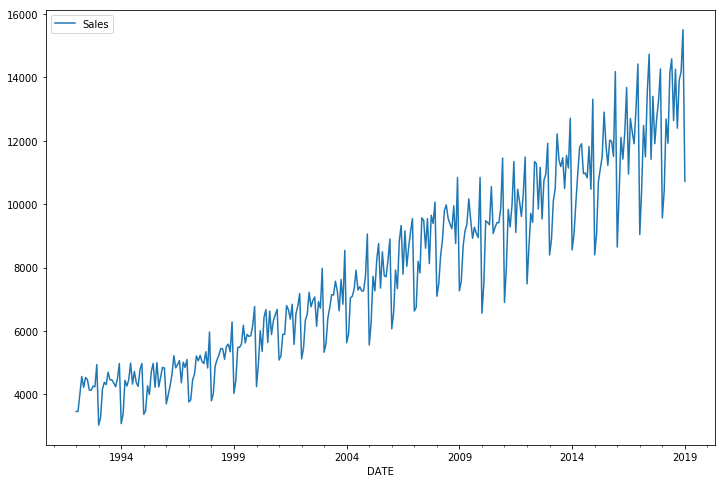

In [7]:
df.plot(figsize=(12,8));

train / test split

In [8]:
train = df.iloc[:313]
test = df.iloc[313:]

Scaling data

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

scaler.fit(train)

C:\anaconda\envs\tsa_course\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
n_input = 12
n_feature = 1
# t시점을 예측하기 위해 t-1,t-2 두 개의 데이터를 사용한다

generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length = n_input,
                               batch_size = 1)

In [33]:
# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


In [34]:
scaled_train[:2]
# train의 데이터 2개를 input 형태로 generate 해줌

array([[0.03658432],
       [0.03649885]])

## create Model

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [35]:
model = Sequential()
model.add( LSTM(100, activation = 'relu', input_shape = (n_input, n_feature) ) )
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [37]:
# fit model
model.fit_generator(generator,epochs=10)

Epoch 1/10
301/301 [==============================] - 3s 11ms/step - loss: 0.0160
Epoch 2/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0098
Epoch 3/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0089
Epoch 4/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0085A: 0s - l
Epoch 5/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0072
Epoch 6/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0059
Epoch 7/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0050
Epoch 8/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0041
Epoch 9/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0032
Epoch 10/10
301/301 [==============================] - 3s 9ms/step - loss: 0.0029


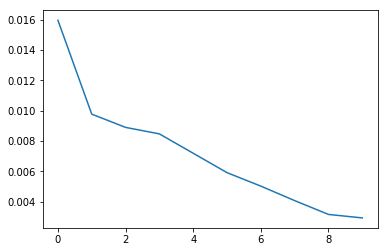

In [38]:
loss_per_epoch = model.history.history['loss']

plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on test data

In [41]:
first_eval_batch = scaled_train[-12:]

In [42]:
first_eval_batch 

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [43]:
first_eval_batch = first_eval_batch.reshape( (1, n_input, n_feature) )

In [44]:
first_eval_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [45]:
model.predict(first_eval_batch)

array([[0.72883254]], dtype=float32)

이제 test 전체를 predict 해보자

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1, n_input, n_feature)

for i in range(len(test)):
    # 여기서 range를 len(test)만큼 했다. 원하는 prediction 만큼 하면 됨
    
    # 현재 pred 값
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [47]:
test_predictions

[array([0.72883254], dtype=float32),
 array([0.82956946], dtype=float32),
 array([0.81334585], dtype=float32),
 array([0.9286577], dtype=float32),
 array([1.0127695], dtype=float32),
 array([0.8159961], dtype=float32),
 array([0.9134717], dtype=float32),
 array([0.8121384], dtype=float32),
 array([0.866158], dtype=float32),
 array([0.9068177], dtype=float32),
 array([0.9712332], dtype=float32),
 array([0.695642], dtype=float32)]

Inverse scaling

In [48]:
true_predictions = scaler.inverse_transform(test_predictions)

In [49]:
test['Predictions'] = true_predictions

C:\anaconda\envs\tsa_course\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
test.head()

,Sales,Predictions
DATE,,
2018-02-01,10415,11557.611919
2018-03-01,12683,12736.133100
2018-04-01,11919,12546.333093
2018-05-01,14138,13895.366556
2018-06-01,14583,14879.389920


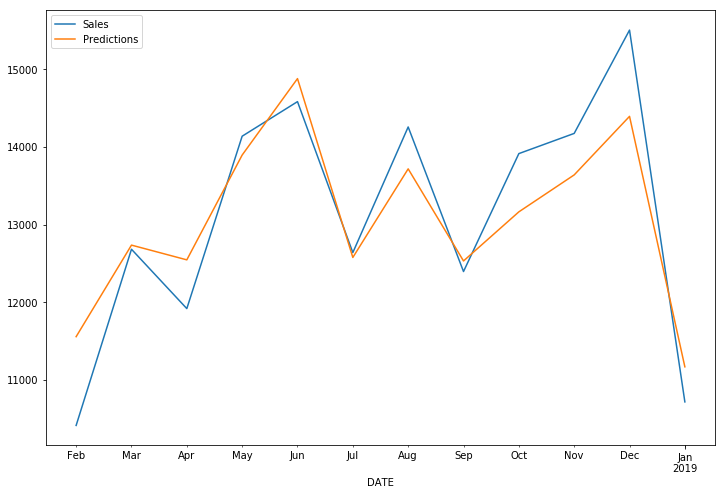

In [53]:
test.plot(figsize=(12,8));

# Saving and Loading Model

In [54]:
# save
model.save('rnn_model.h5')

# load
from keras.models import load_model
new_model = load_model('rnn_model.h5')

In [55]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
